# Prepare GPX File for RGT Magic Road Upload

Use gpxpy for loading GPX File

https://pypi.org/project/gpxpy/

## SRTM Data

https://github.com/tkrajina/srtm.py

Also consider https://gpx-converter.readthedocs.io/en/latest/ for handling GPX data

In [28]:
#!pip install gpxpy --upgrade
#!pip install SRTM.py --upgrade

In [29]:
import gpxpy
import gpxpy.gpx

# Parsing an existing file:
# -------------------------

gpx_file = open('hockenheimring-magic-road.GPX', 'r')

gpx = gpxpy.parse(gpx_file)

#for track in gpx.tracks:
#    for segment in track.segments:
#        for point in segment.points:
#            pass
           # print('Point at ({0},{1}) -> {2}'.format(point.latitude, point.longitude, point.elevation))

gpx_points = gpx.tracks[0].segments[0].points

print(gpx_points[0].latitude)

49.326423928141594


In [30]:
import pandas as pd 

df = pd.DataFrame([[s.latitude, s.longitude, s.elevation] for s in gpx_points], columns=['latitude', 'longitude', 'elevation'])

In [31]:
df

,latitude,longitude,elevation
0,49.326424,8.566839,101.199997
1,49.326458,8.566810,101.199997
2,49.326492,8.566784,101.199997
3,49.326524,8.566759,101.199997
4,49.326555,8.566735,101.199997
...,...,...,...
1175,49.326286,8.566948,107.199997
1176,49.326317,8.566925,107.199997
1177,49.326351,8.566902,107.199997
1178,49.326384,8.566877,107.199997


<AxesSubplot:xlabel='longitude'>

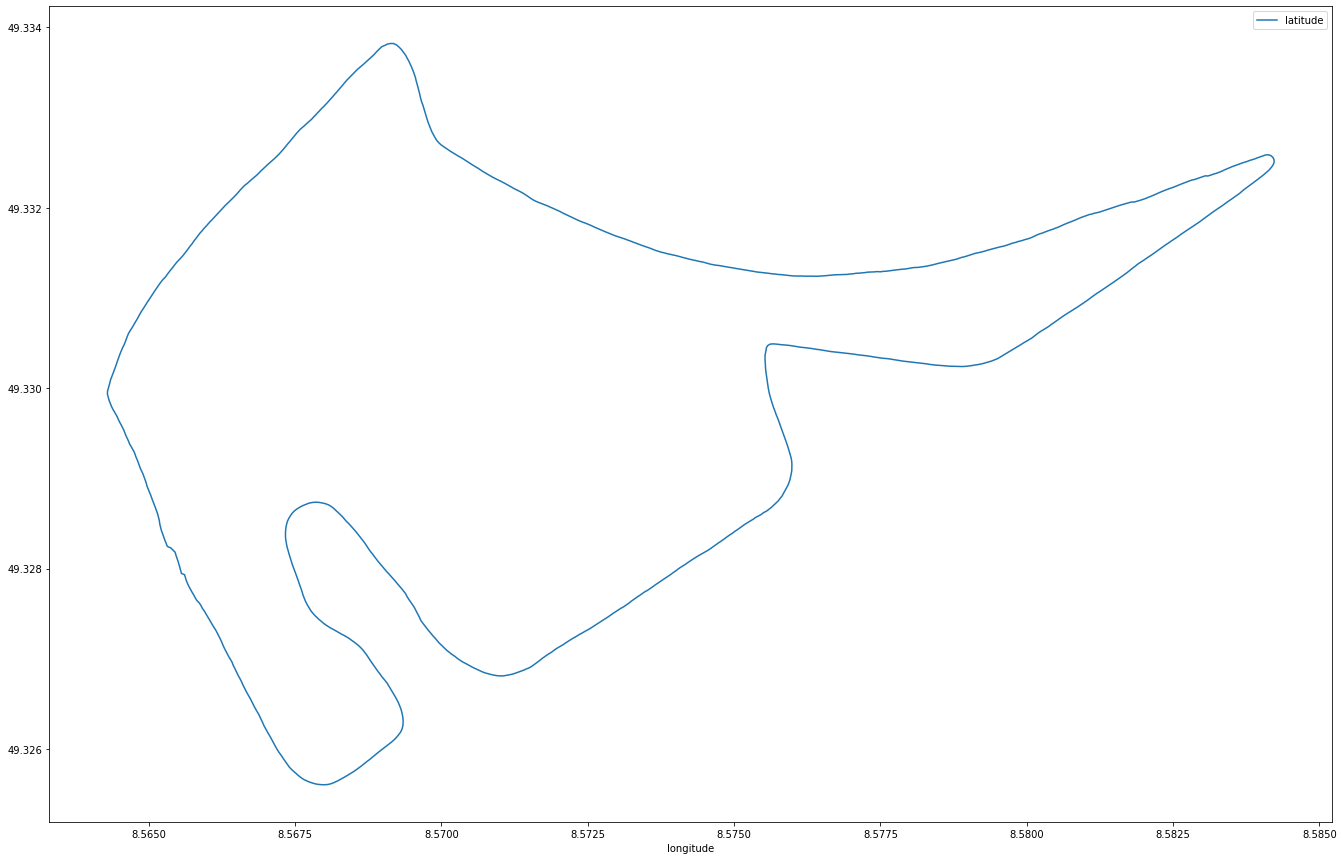

In [33]:
df.plot(x='longitude', y='latitude', figsize=[23, 15])

## Use SRTM data for elevation corrections

Structures on and around the track, such as the spectator stands may cause the SRTM data to be inaccurate

In [35]:
import srtm
elevation_data = srtm.get_data(local_cache_dir="srtmcache") # Cache data so it does not need to be downloaded every time

Creating srtmcache
4 2884802
CGN Airport elevation (meters): 74


In [40]:
print(elevation_data.get_elevation(df.iloc[0].latitude, df.iloc[0].longitude))

103


In [41]:
df['srtm_ele'] = df.apply(lambda x: elevation_data.get_elevation(x['latitude'], x['longitude']), axis=1)

<AxesSubplot:>

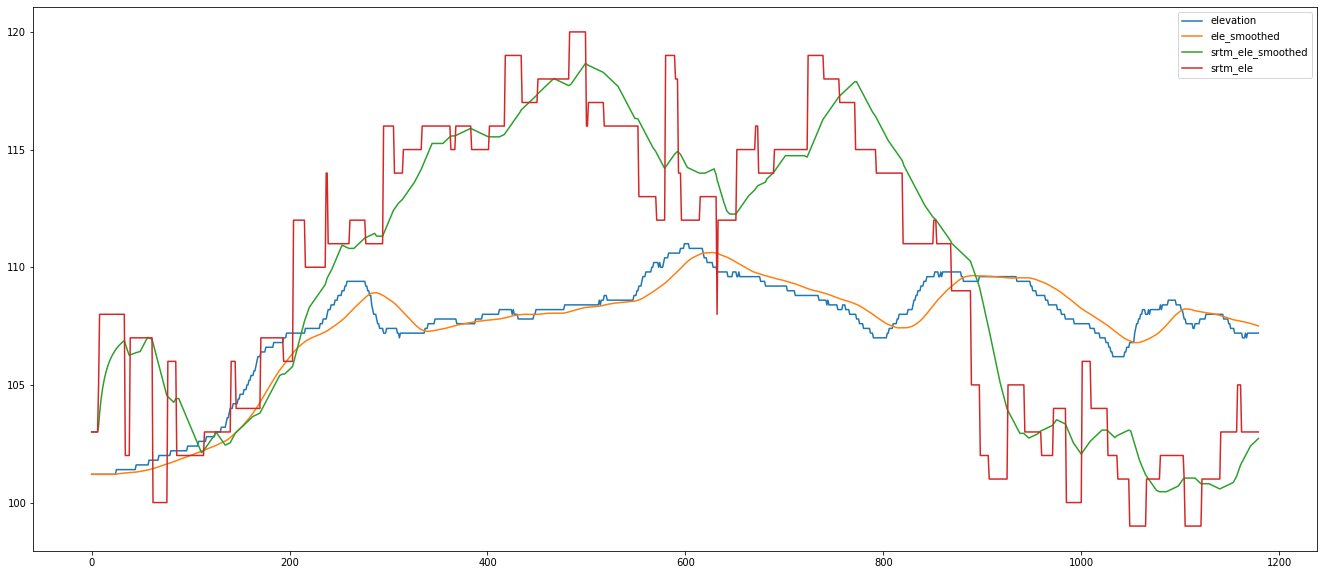

In [75]:
df['srtm_ele_smoothed'] = df['srtm_ele'].rolling(window=50, min_periods=1).mean()
df['ele_smoothed'] = df['elevation'].rolling(window=50, min_periods=1).mean()

# Compare original elevation with SRTM, and with both smoothed:
df[['elevation', 'ele_smoothed', 'srtm_ele_smoothed', 'srtm_ele']].plot(figsize=[23, 10])

## Todo: Smooth GPS Coordinates

Use Kalman Filter to smooth GPS coordinates: https://stackoverflow.com/questions/48739169/how-to-apply-a-rolling-kalman-filter-to-a-column-in-a-dataframe

In [63]:
elevation_data.add_elevations(gpx, smooth=True) # See if the built-in elevation function helps

In [64]:
for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            pass
#            print('Point at ({0},{1}) -> {2}'.format(point.latitude, point.longitude, point.elevation))

84) -> 106.80599601524479
Point at (49.32770040817559,8.573380121961236) -> 106.56899683464026
Point at (49.32767962105572,8.573334775865078) -> 106.32911294016903
Point at (49.327659253031015,8.573289178311825) -> 106.08992219521912
Point at (49.32763746008277,8.573241988196969) -> 105.83966858489909
Point at (49.32761440984905,8.573198989033699) -> 105.62063087620162
Point at (49.32759404182434,8.573154481127858) -> 105.40667428862677
Point at (49.32757551781833,8.573111481964588) -> 105.25639466835139
Point at (49.327559005469084,8.573064962401986) -> 105.10195268282827
Point at (49.32754023000598,8.57301970012486) -> 104.9455249963001
Point at (49.327521789819,8.572974186390638) -> 104.82130475662906
Point at (49.32750150561333,8.572929007932544) -> 104.694141294889
Point at (49.327482394874096,8.572887601330876) -> 104.57653533430341
Point at (49.32746353559196,8.572846613824368) -> 104.46023883854825
Point at (49.32744643650949,8.57280420139432) -> 104.34464138667182
Point at (49

## Export Processed GPX

In [78]:
# Creating a new file:
# --------------------

gpx_out = gpxpy.gpx.GPX()

# Create first track in our GPX:
gpx_track = gpxpy.gpx.GPXTrack()
gpx_out.tracks.append(gpx_track)

# Create first segment in our GPX track:
gpx_segment = gpxpy.gpx.GPXTrackSegment()
gpx_track.segments.append(gpx_segment)

# Create points:
#gpx_segment.points.append(gpxpy.gpx.GPXTrackPoint(2.1234, 5.1234, elevation=1234))
#gpx_segment.points.append(gpxpy.gpx.GPXTrackPoint(2.1235, 5.1235, elevation=1235))
#gpx_segment.points.append(gpxpy.gpx.GPXTrackPoint(2.1236, 5.1236, elevation=1236))

#gpx_segment.points.append(gpxpy.gpx.GPXTrackPoint(x['latitude'], x['longitude'], elevation=x['ele_smoothed']))


df.apply(lambda x: gpx_segment.points.append(gpxpy.gpx.GPXTrackPoint(x['latitude'], x['longitude'], elevation=x['ele_smoothed'])), axis=1)


print('Created GPX:', gpx_out.to_xml())

gpx_file_out = open('hockenheimring-magic-road-processed.GPX', 'w')
gpx_file_out.write(gpx_out.to_xml())

>108.11200057983399</ele>
      </trkpt>
      <trkpt lat="49.328474728390574" lon="8.568447288125753">
        <ele>108.08800048828125</ele>
      </trkpt>
      <trkpt lat="49.32849995791912" lon="8.568413089960814">
        <ele>108.06400039672852</ele>
      </trkpt>
      <trkpt lat="49.328522672876716" lon="8.568374952301383">
        <ele>108.04000030517578</ele>
      </trkpt>
      <trkpt lat="49.328548070043325" lon="8.56834259815514">
        <ele>108.0120002746582</ele>
      </trkpt>
      <trkpt lat="49.32857413776219" lon="8.568308148533106">
        <ele>107.98400024414063</ele>
      </trkpt>
      <trkpt lat="49.328598361462355" lon="8.568270849063993">
        <ele>107.95600021362304</ele>
      </trkpt>
      <trkpt lat="49.32862116023898" lon="8.568232208490372">
        <ele>107.92800018310547</ele>
      </trkpt>
      <trkpt lat="49.32864454574883" lon="8.568195411935449">
        <ele>107.9000001525879</ele>
      </trkpt>
      <trkpt lat="49.32866709306836" l

135645